In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.patches import FancyArrowPatch
import math
import json


LETTER_TO_COL = {'S': 0, 'P': 0, 'D': 2, 'F': 3}

In [2]:
def load_ion_levels(path):
    """
    Load ion energy level and transition data from a JSON file.

    Args:
        path (str): Path to the JSON file.

    Returns:
        dict: Parsed JSON data as a Python dictionary.
    """
    with open(path, "r") as f:
        data = json.load(f)
    return data

"""
Example JSON file content:
    {
        "ion": "88Sr+",
        "levels": [
            {"label": "5s 2S1/2", "energy": 0},
            {"label": "5p 2P1/2", "energy": 23715.19}
        ],
        "transitions": [
            {
                "from": "5s 2S1/2",
                "to": "5p 2P1/2",
                "wavelength": 422,
                "label": "Doppler cooling",
                "color": "blue"
            }
        ]
    }

    Example output:
    {
        'ion': '88Sr+',
        'levels': [{'label': '5s 2S1/2', 'energy': 0}, ...],
        'transitions': [{'from': '5s 2S1/2', 'to': '5p 2P1/2', ...}]
    }
"""

'\nExample JSON file content:\n    {\n        "ion": "88Sr+",\n        "levels": [\n            {"label": "5s 2S1/2", "energy": 0},\n            {"label": "5p 2P1/2", "energy": 23715.19}\n        ],\n        "transitions": [\n            {\n                "from": "5s 2S1/2",\n                "to": "5p 2P1/2",\n                "wavelength": 422,\n                "label": "Doppler cooling",\n                "color": "blue"\n            }\n        ]\n    }\n\n    Example output:\n    {\n        \'ion\': \'88Sr+\',\n        \'levels\': [{\'label\': \'5s 2S1/2\', \'energy\': 0}, ...],\n        \'transitions\': [{\'from\': \'5s 2S1/2\', \'to\': \'5p 2P1/2\', ...}]\n    }\n'

In [3]:
def infer_column(label: str, mapping: dict = LETTER_TO_COL) -> int:
    """
    Extract the term-symbol letter from a spectroscopic label
    (e.g. '5p 2P3/2') and return its column index.
    """
    try:
        letter = label.split()[1][1]
        return mapping.get(letter, 0)
    except (IndexError, KeyError):
        return 0
def format_ion_label(ion: str) -> str:
    """
    Convert a string like '88Sr+' into LaTeX-formatted
    superscript label for matplotlib, e.g. '$^{88}\\mathrm{Sr}^{+}$'
    """
    import re
    match = re.match(r"(\d+)([A-Za-z]+)([+-]\d*|\+|-)?", ion)
    if match:
        isotope, element, charge = match.groups()
        charge = charge or ""
        return fr"$^{{{isotope}}}\mathrm{{{element}}}^{{{charge}}}$"
    else:
        return ion
def format_term_symbol(label: str) -> str:
    """
    Convert a raw label like '5s 2S1/2' into a
    Matplotlib math-text string for proper typesetting.
    """
    try:
        orb, term = label.split(maxsplit=1)
        m = re.match(r"(\d)([SPDF])(\d)/(\d)", term)
        if not m:
            return label
        multiplicity, L, num, den = m.groups()
        return rf"${orb}\,^{multiplicity}{L}_{{{num}/{den}}}$"
    except ValueError:
        return label

def group_levels_by_column(levels: list) -> dict:
    """
    Group a list of level dicts by their column index.
    Returns mapping: column_index -> [levels].
    """
    cols = {}
    for lvl in levels:
        col = infer_column(lvl['label'])
        cols.setdefault(col, []).append(lvl)
    return cols

def compute_x_map(groups: dict,
                  spacing: float,
                  bar_half: float,
                  x_jitter: float) -> dict:
    """
    x_jitter = max offset (in data coords) away from the column center.
    """
    x_map = {}
    for col, lvls in groups.items():
        base_x = 0.25 * spacing * (col - 1)
        n = len(lvls)
        # spread them evenly between -x_jitter ... +x_jitter
        offsets = np.linspace(-x_jitter, +x_jitter, n) if n > 1 else [0]
        for lvl, off in zip(lvls, offsets):
            x_map[lvl['label']] = base_x + off
    return x_map

def compute_y_map(groups: dict, bar_half: float) -> dict:
    """
    Assign each level a y-position with optional jitter
    to avoid exact overlaps. Returns mapping: label -> y.
    """
    y_map = {}
    for lvls in groups.values():
        energies = np.array([lvl['energy'] for lvl in lvls])
        n = len(lvls)
        jitter = bar_half * 3000
        offsets = np.linspace(-jitter, +jitter, n) if n > 1 else [0]
        order = np.argsort(energies)
        for i, idx in enumerate(order):
            lbl = lvls[idx]['label']
            y_map[lbl] = energies[idx] + offsets[i]
    return y_map

In [4]:
def plot_energy_levels(data: dict,
                       spacing: float = 1,
                       bar_half: float = 0.1,
                       x_jitter: float = 0.2,
                       label_offset: float = -0.4,
                       text_vpad: float = 5000,
                       title_pad: float = 20,
                       ylabel_pad: float = 15,
                       show_axis: bool = False,
                       left_margin: float = 0.2) -> None:
    """
    Plot an energy-level diagram given JSON-like data:
      {
        'ion': str,
        'unit': str,
        'levels': [{'label': str, 'energy': float}, ...],
        'transitions': [{'from': str, 'to': str, 'wavelength': float, 'label': str, 'color': str}, ...]
      }
    """
    levels = data.get('levels', [])
    transitions = data.get('transitions', [])

    # Group and map positions
    col_groups = group_levels_by_column(levels)
    x_map = compute_x_map(col_groups, spacing, bar_half, x_jitter)
    y_map = compute_y_map(col_groups, bar_half)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Draw levels + labels (labels at bar’s right end)
    for lbl, x in x_map.items():
        y = y_map[lbl]

        # draw the horizontal bar
        ax.hlines(y, x - bar_half, x + bar_half, color='k', lw=2)

        # compute text position: right end of bar + small padding
        pad = 0.02  # horizontal padding in data units
        x_text = x + bar_half + pad
        y_text = y      # center vertically on the bar

        ax.text(
            x_text,
            y_text,
            format_term_symbol(lbl),
            va='center',    # vertical align center on the bar
            ha='left',      # left-align so text extends to the right
            fontsize=9
        )

    # Draw transitions
    for t in transitions:
        x1, y1 = x_map[t['from']], y_map[t['from']]
        x2, y2 = x_map[t['to']],   y_map[t['to']]
        color      = t.get('color',    'k')
        rev        = t.get('reversible', False)
        style      = t.get('style',    'solid')  # "solid" or "dotted"
        lw         = 2
        ls         = '-' if style=='solid' else ':'

        # 1) line or arrow-only
        if rev:
            ax.plot([x1, x2], [y1, y2],
                    linestyle=ls, color=color, lw=lw)
        else:
            arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                    arrowstyle='->',
                                    mutation_scale=10,
                                    color=color, lw=lw,
                                    linestyle=ls)
            ax.add_patch(arrow)

    # 2) single label, offset perpendicular to the line
        mx, my   = (x1 + x2)/2, (y1 + y2)/2
        dx, dy   = x2 - x1, y2 - y1
        L        = math.hypot(dx, dy)
        ux, uy   = dx/L, dy/L
        px, py   = -uy, ux
        shift    = 0.075 # 0.1 * L
        tx, ty   = mx + px*shift, my + py*shift

        ax.text(tx, ty,
                f"{t.get('label','')}",
                va='center', ha='center', fontsize=8)


    # Cosmetics
    ion = data.get('ion', '')
    ion_label = format_ion_label(ion)
    ax.set_title(f"{ion_label} Energy Levels", pad=title_pad)
    ax.set_ylabel(f"Energy ({data.get('unit','cm$^{-1}$')})", labelpad=ylabel_pad)
    ax.set_xticks([])
    y_vals = list(y_map.values())
    ax.set_ylim(min(y_vals) - spacing, max(y_vals) + spacing)
    x_vals = list(x_map.values())
    ax.set_xlim(min(x_vals) - spacing/2, max(x_vals) + spacing/2)

    if show_axis:
        # show only left axis
        for side in ['top','right','bottom']:
            ax.spines[side].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.yaxis.set_visible(True)
        ax.set_ylabel(f"Energy ({data.get('unit','cm$^{-1}$')})",
                      labelpad=ylabel_pad)
    else:
        # turn absolutely everything off
        ax.axis('off')

    fig.subplots_adjust(left=left_margin)
    plt.tight_layout()
    plt.show()

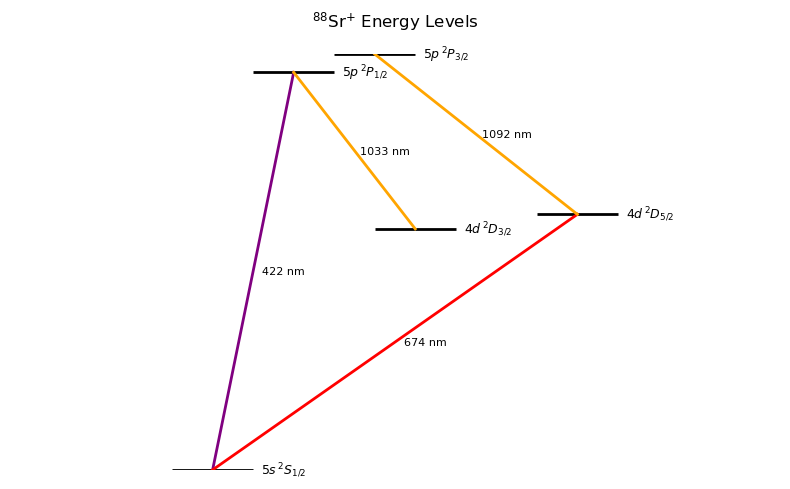

In [5]:
data = load_ion_levels(r"C:\Users\iks14535\NQCC\SrZeeman\sr88_base.json")

plot_energy_levels(data)